In [1]:
import warnings
warnings.filterwarnings("ignore")
import os, time, re, tqdm, math # utility libraries for computation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#To scale the data using z-score 
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

#Algorithms to use
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

#To tune the model
from sklearn.model_selection import GridSearchCV

#Metrics to evaluate the model
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
import gc

In [2]:
start = time.time()

# define path variables
train_path = '../input/amex-default-prediction/train_data.csv'
train_labels_path = '../input/amex-default-prediction/train_labels.csv'

# define chunk size
chunk_size = 20000
# load dataset with given chunksize
train_data = pd.read_csv(train_path, low_memory=False, chunksize=chunk_size)
train_labels = pd.read_csv(train_labels_path, chunksize=chunk_size)

end = time.time()
print('Time Taken: %.3f seconds' % (end-start))

Time Taken: 0.024 seconds


In [3]:
start = time.time()

# define path variables
test_path = '../input/amex-default-prediction/test_data.csv'

# define chunk size
chunk_size = 20000
# load dataset with given chunksize
test_data = pd.read_csv(test_path, low_memory=False, chunksize=chunk_size)

end = time.time()
print('Time Taken: %.3f seconds' % (end-start))

Time Taken: 0.010 seconds


In [4]:
train_data = train_data.__next__()
train_labels = train_labels.__next__()

In [5]:
test_data = test_data.__next__()

In [6]:
train_labels.drop('customer_ID', axis=1, inplace=True)
train_data = pd.concat([train_data, train_labels], axis=1)

In [7]:
train_data.drop('customer_ID', axis=1, inplace=True)
submission_file = test_data['customer_ID']
test_data.drop('customer_ID', axis=1, inplace=True)

In [8]:
num_cols = train_data.select_dtypes('number').columns
train_data[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
P_2,19851.0,0.659791,0.243801,-2.569212e-01,0.480397,0.699095,0.868872,1.009926
D_39,20000.0,0.152223,0.268263,8.701630e-07,0.004582,0.009219,0.214144,5.009303
B_1,20000.0,0.128426,0.218512,-1.414690e-01,0.008930,0.033051,0.131177,1.323981
B_2,19998.0,0.609829,0.404588,8.675709e-06,0.088689,0.813778,1.002129,1.010000
R_1,20000.0,0.076314,0.218224,3.154721e-07,0.002874,0.005768,0.008637,2.502416
...,...,...,...,...,...,...,...,...
D_142,3203.0,0.365908,0.244865,-8.804185e-03,0.153710,0.353421,0.546272,1.486382
D_143,19654.0,0.167112,0.368618,2.360950e-07,0.002967,0.005949,0.008926,1.010000
D_144,19851.0,0.048560,0.178911,5.802874e-07,0.002684,0.005383,0.008146,1.343284
D_145,19654.0,0.055100,0.201799,1.577788e-07,0.002994,0.005987,0.008958,4.282032


In [9]:
def random_imputation(x, df):
    random_sample = df[x].dropna().sample(df[x].isna().sum(), replace=True)
    random_sample.index = df[df[x].isnull()].index
    df.loc[df[x].isnull(), x] = random_sample
    return df

# define imputation mode    
def imputation_mode(x, df):
    mode = df[x].mode()[0]
    df[x] = df[x].fillna(mode)
    return df

In [10]:
for c in num_cols:
    train_data = imputation_mode(c, train_data)
    
for c in num_cols:
    if c!='target':
        test_data = imputation_mode(c, test_data)

In [11]:
train_data['Date'] = pd.to_datetime(train_data['S_2'],infer_datetime_format=True, format='%Y/%m/%d %H:%M:%S')
train_data.drop('S_2', axis=1, inplace=True)

train_data['Date_Year'] = train_data['Date'].dt.year.astype('string')
train_data['Date_Month'] = train_data['Date'].dt.month.astype('string')
train_data['Date_week'] = train_data['Date'].dt.week.astype('string')
train_data.drop('Date', axis=1, inplace=True)

In [12]:
test_data['Date'] = pd.to_datetime(test_data['S_2'],infer_datetime_format=True, format='%Y/%m/%d %H:%M:%S')
test_data.drop('S_2', axis=1, inplace=True)

test_data['Date_Year'] = test_data['Date'].dt.year.astype('string')
test_data['Date_Month'] = test_data['Date'].dt.month.astype('string')
test_data['Date_week'] = test_data['Date'].dt.week.astype('string')
test_data.drop('Date', axis=1, inplace=True)

In [13]:
cat_cols = ['D_87','B_31','D_66','D_114','D_116','D_120','B_30','D_126','B_38','D_68','D_117','D_63','D_64','Date_Year','Date_Month','Date_week']

In [14]:
train_data['D_87'] = train_data['D_87'].astype('string')
train_data['B_31'] = train_data['B_31'].astype('string')
train_data['D_66'] = train_data['D_66'].astype('string')
train_data['D_114'] = train_data['D_114'].astype('string')
train_data['D_116'] = train_data['D_116'].astype('string')
train_data['D_120'] = train_data['D_120'].astype('string')
train_data['B_30'] = train_data['B_30'].astype('string')
train_data['D_126'] = train_data['D_126'].astype('string')
train_data['B_38'] = train_data['B_38'].astype('string')
train_data['D_68'] = train_data['D_68'].astype('string')
train_data['D_117'] = train_data['D_117'].astype('string')

In [15]:
test_data['D_87'] = test_data['D_87'].astype('string')
test_data['B_31'] = test_data['B_31'].astype('string')
test_data['D_66'] = test_data['D_66'].astype('string')
test_data['D_114'] = test_data['D_114'].astype('string')
test_data['D_116'] = test_data['D_116'].astype('string')
test_data['D_120'] = test_data['D_120'].astype('string')
test_data['B_30'] = test_data['B_30'].astype('string')
test_data['D_126'] = test_data['D_126'].astype('string')
test_data['B_38'] = test_data['B_38'].astype('string')
test_data['D_68'] = test_data['D_68'].astype('string')
test_data['D_117'] = test_data['D_117'].astype('string')

In [16]:
#creating dummy variables
train_data = pd.get_dummies(data = train_data, columns= cat_cols, drop_first= True)  
test_data = pd.get_dummies(data = test_data, columns= cat_cols, drop_first= True)    

In [17]:
cols_to_drop = train_data.columns.difference(test_data.columns)

In [18]:
X = train_data.drop(['target'], axis=1)
X = train_data.drop(cols_to_drop, axis=1)

Y = pd.DataFrame(train_data['target'])

In [19]:
#Splitting the data into train and test sets
x_train,x_test,y_train,y_test=train_test_split(X, Y, test_size=0.30, random_state=1,stratify=Y)

In [20]:
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Not Defaulted', 'Defaulted'], yticklabels=['Not Defaulted', 'Defaulted'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [21]:
from catboost import CatBoostClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve,recall_score
from catboost import Pool, cv

In [22]:
booster = CatBoostClassifier(eval_metric='Recall')

params = {
            'iterations':[5,10,50,100,200,500],
            'learning_rate':[0.01, 0.03, 0.1,0.5],
            'bootstrap_type':['Bayesian', 'Bernoulli', 'MVS', 'No']
}

search_results = booster.randomized_search(params, x_train, y_train, cv=5, verbose=False)

print("\nBest Params : ", search_results['params'])

test_preds = booster.predict(x_test)
train_preds = booster.predict(x_train)



0:	learn: 0.0030426	test: 0.0027397	best: 0.0027397 (0)	total: 95.5ms	remaining: 382ms
1:	learn: 0.0030426	test: 0.0027397	best: 0.0027397 (0)	total: 129ms	remaining: 194ms
2:	learn: 0.0000000	test: 0.0000000	best: 0.0027397 (0)	total: 163ms	remaining: 109ms
3:	learn: 0.0000000	test: 0.0000000	best: 0.0027397 (0)	total: 208ms	remaining: 52ms
4:	learn: 0.0000000	test: 0.0000000	best: 0.0027397 (0)	total: 245ms	remaining: 0us

bestTest = 0.002739726027
bestIteration = 0

0:	learn: 0.0033807	test: 0.0013699	best: 0.0013699 (0)	total: 44.4ms	remaining: 178ms
1:	learn: 0.0030426	test: 0.0013699	best: 0.0013699 (0)	total: 76.8ms	remaining: 115ms
2:	learn: 0.0033807	test: 0.0013699	best: 0.0013699 (0)	total: 109ms	remaining: 72.9ms
3:	learn: 0.0033807	test: 0.0013699	best: 0.0013699 (0)	total: 140ms	remaining: 35ms
4:	learn: 0.0037187	test: 0.0013699	best: 0.0013699 (0)	total: 170ms	remaining: 0us

bestTest = 0.001369863014
bestIteration = 0

0:	learn: 0.0013523	test: 0.0013699	best: 0.001369

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.11 µs
              precision    recall  f1-score   support

           0       0.74      0.88      0.80      4419
           1       0.25      0.11      0.16      1581

    accuracy                           0.68      6000
   macro avg       0.49      0.50      0.48      6000
weighted avg       0.61      0.68      0.63      6000



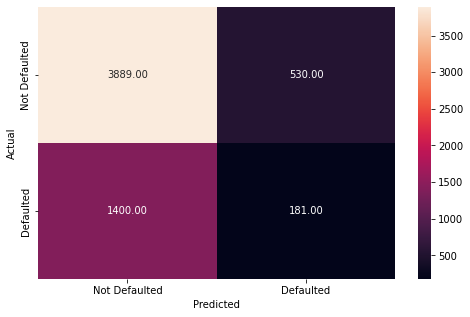

In [23]:
clf = CatBoostClassifier(eval_metric='Recall')

clf.set_params(iterations=search_results['params']['iterations'],learning_rate=search_results['params']['learning_rate'],bootstrap_type=search_results['params']['bootstrap_type'])

%time
clf.fit(x_train,y_train, verbose=False)

y_predicted = clf.predict(x_test)
y_scores = metrics_score(y_test, y_predicted)

<AxesSubplot:xlabel='Importance'>

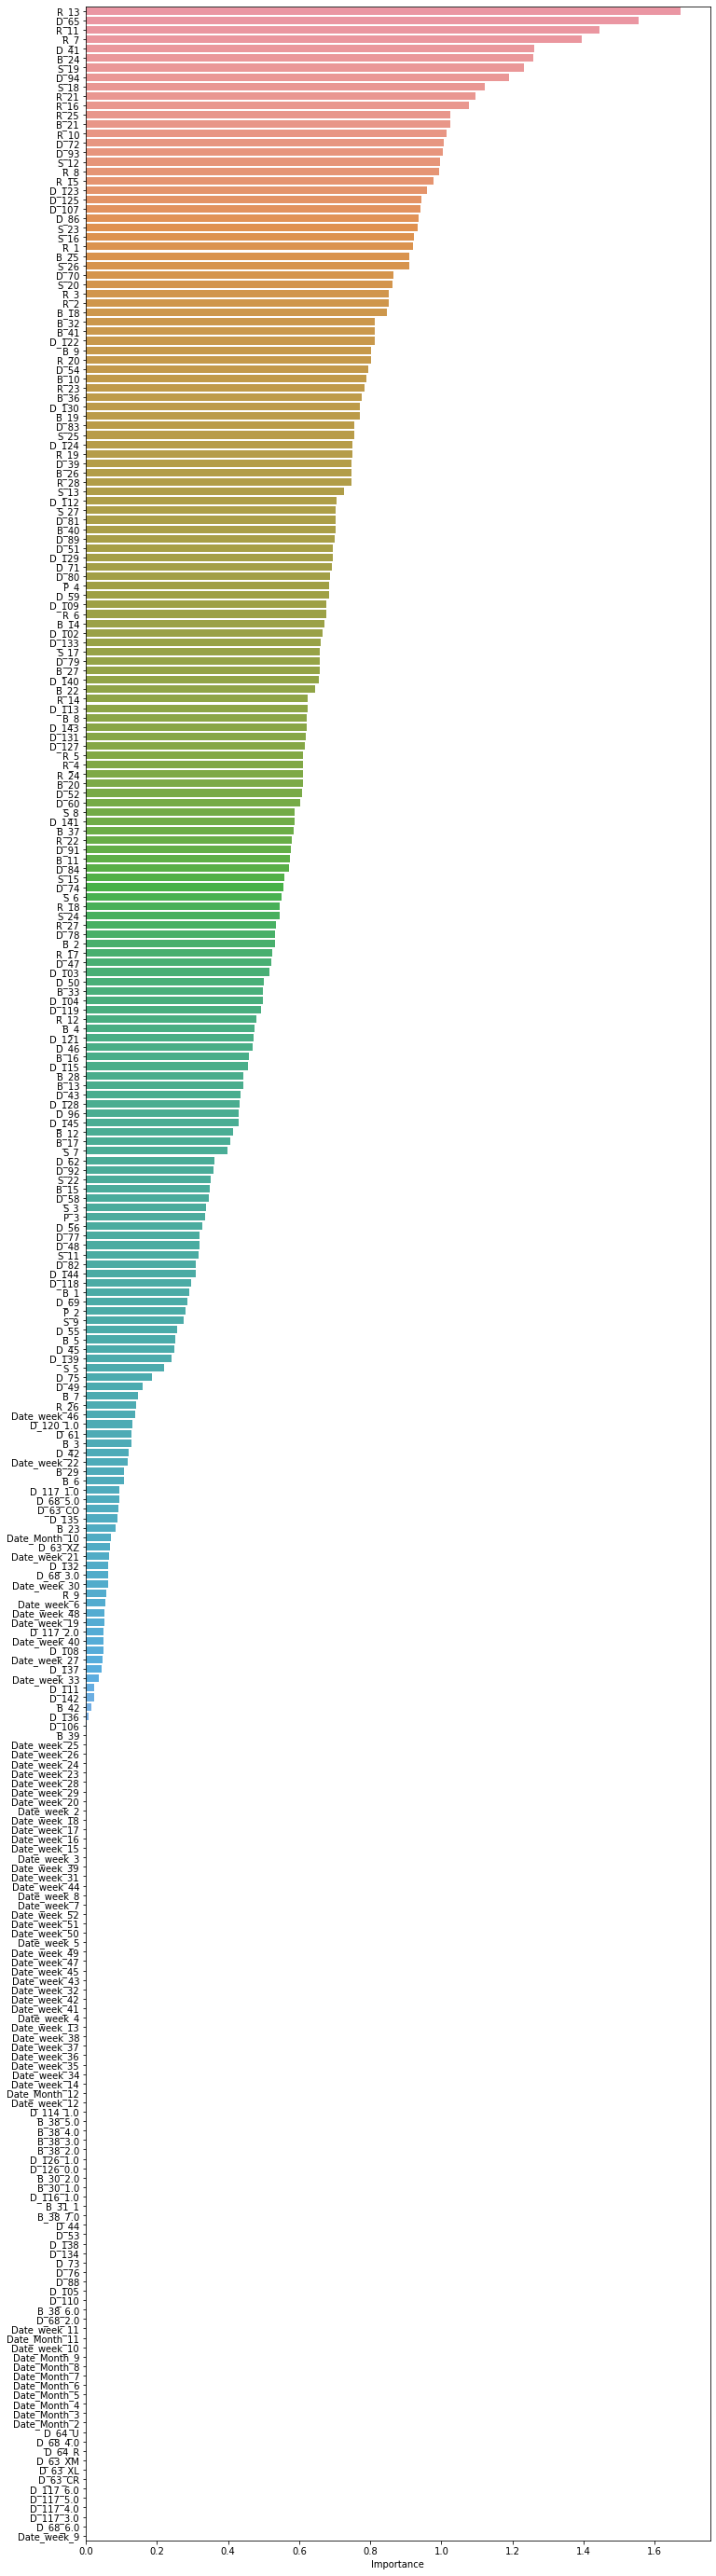

In [24]:
importances = clf.feature_importances_
columns=X.columns
importance_df=pd.DataFrame(importances,index=columns,columns=['Importance']).sort_values(by='Importance',ascending=False)
plt.figure(figsize=(12,50))
sns.barplot(importance_df.Importance,importance_df.index)

In [25]:
submission_file = pd.DataFrame(submission_file)

In [26]:
submission_file['prediction'] = clf.predict(test_data)

In [27]:
submission_file

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0
1,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0
2,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0
3,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0
4,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0
...,...,...
19995,007317e5c6dcf137fd9310b2a4b385822f01bd30b345c5...,0
19996,007317e5c6dcf137fd9310b2a4b385822f01bd30b345c5...,1
19997,007317e5c6dcf137fd9310b2a4b385822f01bd30b345c5...,0
19998,007317e5c6dcf137fd9310b2a4b385822f01bd30b345c5...,0


In [28]:
submission_file.to_csv("submission.csv", index=False)